In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import helper_functions as hf
from data import get_temperatures, interpolate_temperature

#### Upload Data

TODO: check rfi differences between calibration methods, get noise with calib cuts (laurie)

In [323]:
instrument = '100MHz'
year = '2021'
channel = 'EW' 

path2file = f'../Data/{year}/{instrument[:-3]}/{channel}/'
file_ending = f'_{year}_{instrument[:-3]}{channel}.npy'

with open(path2file + 'antenna' + file_ending, 'rb') as f:
    P_ant = np.load(f)
with open(path2file + 'res50' + file_ending, 'rb') as f:
    P_50 = np.load(f)
with open(path2file + 'res100' + file_ending, 'rb') as f:
    P_100 = np.load(f)
with open(path2file + 'shorts' + file_ending, 'rb') as f:
    P_short = np.load(f)
with open(path2file + 'systime' + file_ending, 'rb') as f:
    systime = np.load(f)
with open(path2file + 'lst' + file_ending, 'rb') as f:
    lst = np.load(f)

with open(f'../Data/noise_2021_{instrument[:-3]}{channel}.npy', 'rb') as f: #### download properly
    P_noise = np.load(f)    
    
# rfi flagged data & freq
with open(f'RFI_flagged/rfi_flagged_{instrument[:-3]}{channel}_oldfreq.npz', 'rb') as f:
    data_file = np.load(f)
    flag_mask = np.isnan(data_file['data'])
    freq = data_file['freq']

FileNotFoundError: [Errno 2] No such file or directory: '../Data/noise_2021_100EW.npy'

In [ ]:
# truncate all power data to optimal frequency range
raw_freq = np.arange(0, 250, 250/4096)
highpass = 49.5
lowpass = 135.5

P_ant, _ = hf.truncate(P_ant, raw_freq, highpass, lowpass)
P_short, _ = hf.truncate(P_short, raw_freq, highpass, lowpass)
P_50, _ = hf.truncate(P_50, raw_freq, highpass, lowpass)
P_100, _ = hf.truncate(P_100, raw_freq, highpass, lowpass)
P_noise, _ = hf.truncate(P_noise, raw_freq, highpass, lowpass)

In [ ]:
# apply rfi flag mask to antenna
P_ant[flag_mask] = np.nan

In [ ]:
for t in range(0, 1000, 100):
    plt.plot(freq, P_100[t])
    plt.plot(freq, P_50[t])
    plt.plot(freq, P_short[t])
    plt.plot(freq, P_noise[t])
#     plt.plot(freq, P_ant[t])

In [329]:
t = 10000
# for f in range(500, len(freq), 500):
#     plt.plot(lst[:t], P_short[:t, f])
plt.plot(rfi_freq, P_100[t], 'b', label='res100')
#     plt.plot(systime[:t], P_50[:t, f], 'g', label='res50')
#     plt.plot(systime[:t], P_noise[:t, f], 'r', label='noise')
# #     plt.plot(systime[:t], P_ant[:t, f])
plt.legend()

NameError: name 'rfi_freq' is not defined

#### calib type

In [315]:
calib = 'noise' # ambient

#### Temperatures

TODO: check if channels flipped in temps 100MHz

In [316]:
# path to temperature directories (2021 only)
path2dir = f'/project/s/sievers/prizm/marion2022/prizm-{instrument[:-3]}/data_{instrument}/temperatures'

if calib == 'ambient':
    temp_type = 'ambient'
elif calib == 'noise':
    temp_type = f'{instrument[:-3]}{channel}_noise'
    
T_phys = get_temperatures(instrument, path2dir, temp_type=temp_type)
T_phys, systime_phys, interp_inds = interpolate_temperature(T_phys[f'temp_{temp_type}'], (T_phys['time_sys_start'] + T_phys['time_sys_stop']) / 2, systime)

#### TODO: transmission eff

In [ ]:
###### upload eta
eta_ant = []
eta_50 = []
eta_100 = []

#### Calibration Factor

In [226]:
def K_JNC_ambient(Z, P_short, P_50, P_100, eta_50, eta_100, T_amb, delta_t=6.4, delta_nu=250/4096): #### check actual integration time. seconds or hours?
    '''
    Parameters:
        delta_nu (float): frequency channel width, MHz
        delta_t (float): integration time, seconds or h ? TODO
    '''
    if Z == 50:
        eta_Z = eta_50
        P_load = P_50
    elif Z == 100:
        eta_Z = eta_100
        P_load = P_100
    else:
        print('Z (impedence) must be 50 or 100')
        
    P_Z = (P_50 - P_100) / (eta_50 - 4 * eta_100) * Z**2 * eta_Z
    
    return T_amb[:, None] / (P_load - P_Z - P_short) #  - P_thermal(P_load, delta_t=delta_t, delta_nu=delta_nu))


def K_JNC_noise(T_noise, P_noise, P_res):
    return T_noise[:, None] / (P_noise - P_res)
    

def P_thermal(P_tot, delta_t=6.4, delta_nu=250/4096):
    delta_nu *= 1e6 # convert MHz to Hz
    return P_tot / np.sqrt(delta_nu * delta_t)

In [245]:
#### temporary test
def K_JNC_noZ(Z, P_short, P_50, P_100, T_amb, delta_t=6.4, delta_nu=250/4096): #### check actual integration time. seconds or hours?
    '''
    Parameters:
        delta_nu (float): frequency channel width, MHz
        delta_t (float): integration time, seconds or h ? TODO
    '''
    if Z == 50:
        P_load = P_50
    elif Z == 100:
        P_load = P_100
    else:
        print('Z (impedence) must be 50 or 100')
    
    return T_amb[:, None] / (P_load - P_short) #  - P_thermal(P_load, delta_t=delta_t, delta_nu=delta_nu))

K_JNC = K_JNC_noZ(100, P_short[interp_inds], P_50[interp_inds], P_100[interp_inds], T_phys)

In [227]:
integration_time = np.median(np.diff(systime))
freq_width = 250/4096

In [234]:
# JNC K from impedance loads
Z = 50
if calib == 'ambient':
    K_JNC = K_JNC(Z, P_short[interp_inds], P_50[interp_inds], P_100[interp_inds], eta_50, eta_100, \
              T_phys, delta_t=integration_time, delta_nu=freq_width)
elif calib == 'noise':
    if Z == 50:
        K_JNC = K_JNC_noise(T_phys, P_noise[interp_inds], P_50[interp_inds])
    if Z == 100:
        K_JNC = K_JNC_noise(T_phys, P_noise[interp_inds], P_100[interp_inds])

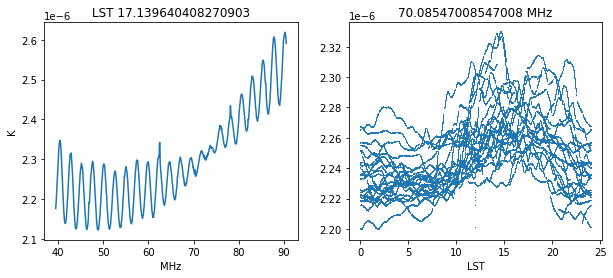

In [246]:
f = 500
t = 10000

fig = plt.figure(figsize=(10,4))
ax = fig.subplots(1,2)
# ax[0].grid()
ax[0].set_title(f'LST {lst[interp_inds][t]}')
ax[0].set_ylabel('K')
ax[0].set_xlabel('MHz')
ax[0].plot(freq, K_JNC[t])

# ax[1].grid()
ax[1].set_title(f'{freq[f]} MHz')
ax[1].set_xlabel('LST')
ax[1].plot(lst[interp_inds], K_JNC[:, f], ',')

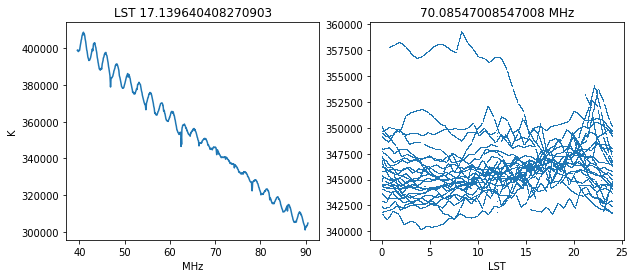

In [230]:
f = 500
t = 10000

fig = plt.figure(figsize=(10,4))
ax = fig.subplots(1,2)
# ax[0].grid()
ax[0].set_title(f'LST {lst[interp_inds][t]}')
ax[0].set_ylabel('K')
ax[0].set_xlabel('MHz')
ax[0].plot(freq, P_thermal(P_noise[interp_inds])[t])

# ax[1].grid()
ax[1].set_title(f'{freq[f]} MHz')
ax[1].set_xlabel('LST')
ax[1].plot(lst[interp_inds], P_thermal(P_noise[interp_inds])[:, f], ',')

#### Calibrate

In [247]:
eta_ant = 1
Tsky = K_JNC * (P_ant[interp_inds] - P_short[interp_inds]) / eta_ant

#### Compare to GSM

In [201]:
Tgsm = np.load(f'GSM_averages/{instrument}_{channel}_GSM_average_2minbins_horizon_0align.npy')
gsm_flow = 30

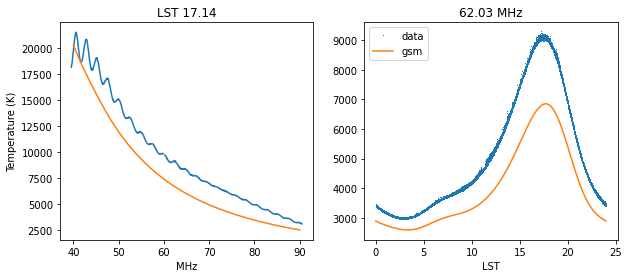

In [286]:
f = 368
t = 10000

# adjust these to match data freq/lst
f_gsm = 62
lst_gsm = 17.14
offset = 0

k1 = 1.39
k2 = -700

fig = plt.figure(figsize=(10,4))
ax = fig.subplots(1,2)
# ax[0].grid()
ax[0].set_title(f'LST {round(lst[interp_inds][t],2)}')
ax[0].set_ylabel('Temperature (K)')
ax[0].set_xlabel('MHz')
ax[0].plot(freq, Tsky[t])
ax[0].plot(range(40, 92, 2), Tgsm[(np.arange(720)+offset)%720][int(lst_gsm * 30), (40-gsm_flow)//2:(92-gsm_flow)//2], label='gsm')

# ax[1].grid()
ax[1].set_title(f'{round(freq[f],2)} MHz')
ax[1].set_xlabel('LST')
ax[1].plot(lst[interp_inds], Tsky[:, f], ',', label='data')
ax[1].plot(lst_2min, Tgsm[(np.arange(720)+offset)%720, (f_gsm - gsm_flow)//2], label='gsm')
ax[1].legend()

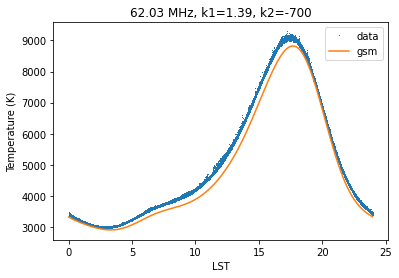

In [291]:
# scale/offset correction
k1 = 1.39
k2 = -700

plt.title(f'{round(freq[f],2)} MHz, k1={k1}, k2={k2}')
plt.xlabel('LST')
plt.ylabel('Temperature (K)')
plt.plot(lst[interp_inds], Tsky[:, f], ',', label='data')
plt.plot(lst_2min, Tgsm[(np.arange(720)+offset)%720, (f_gsm - gsm_flow)//2] * k1 + k2, label='gsm')
plt.legend()

### Binned

In [129]:
# bin data to compare with Tgsm
binsize_f = 1
binsize_t = 2
flow = 40
fhigh = 90
Tsky_binned, freq_1mhz, lst_2min, bin_inds_f, bin_inds_t = hf.binning(Tsky, freq, lst[interp_inds], binsize_f, binsize_t, flow, fhigh)

In [135]:
# bin sky power
Psky_binned, freq_1mhz, lst_2min, bin_inds_f, bin_inds_t = hf.binning(P_ant[interp_inds] - P_short[interp_inds] - \
                                                                      P_thermal(P_ant[interp_inds], delta_t=integration_time, delta_nu=freq_width), \
                                                                      freq, lst[interp_inds], binsize_f, binsize_t, flow, fhigh)

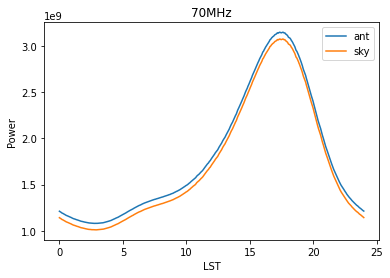

In [241]:
f = 70
fig = plt.figure()
plt.title(f'{f}MHz')
plt.ylabel('Power')
plt.xlabel('LST')
plt.plot(lst_2min, Pant_binned[:, (f - flow)], label='ant')
plt.plot(lst_2min, Psky_binned[:, (f - flow)], label='sky')
plt.legend()

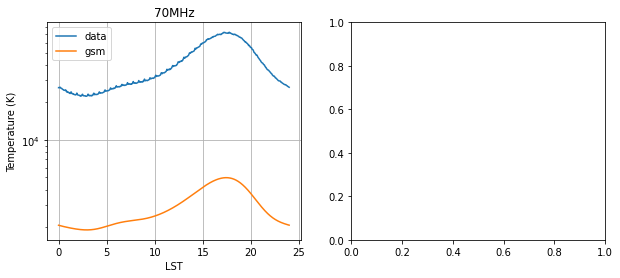

In [149]:
f = 70
offset = 10

fig = plt.figure(figsize=(10,4))
ax = fig.subplots(1,2)
ax[0].grid()
ax[0].set_yscale('log')
ax[0].set_title(f'{f}MHz')
ax[0].set_ylabel('Temperature (K)')
ax[0].set_xlabel('LST')
ax[0].plot(lst_2min, Tsky_binned[:, (f - flow)], label='data')
ax[0].plot(lst_2min, Tgsm[(np.arange(720)+offset)%720, (f - gsm_flow)//2], label='gsm')
ax[0].legend()

# ax[1].grid()
# ax[1].set_ylabel('residual (K)')
# ax[1].set_xlabel('LST')
# ax[1].plot(lst_2min, Tsky_binned[:, (f - flow)] - Tgsm[(np.arange(720)+offset)%720, (f - gsm_flow)//2])